In [35]:
from kedro.io import DataCatalog
import yaml
import logging

logger = logging.getLogger(__name__)

with open("catalog.yml") as f:
    conf_catalog = yaml.safe_load(f)

catalog = DataCatalog.from_config(conf_catalog)

with open("parameters.yml", encoding="utf-8") as yaml_file:
    params = yaml.safe_load(yaml_file)

paa_image = catalog.load("paa_12_image")
paa_label = catalog.load("paa_12_label")
paa_roi = catalog.load("paa_12_roi")

batch_image = catalog.load("batch_paa_12")
batch_roi = catalog.load("batch_paa_12_roi")

epochs = params["tune_sam"]["epochs"]
print(len(paa_image))
print(epochs)

201
30


# Data Preprocessing: Label and Image Pairing

## Label contstruction from JSON

In [16]:
# from datasets import load_dataset
# dataset = load_dataset("nielsr/breast-cancer", split="train")
from utils.parse_label_json import LabelParser
from typing import List, Dict
import numpy as np

def prepare_masks(label_json: List[Dict]) -> Dict[str, np.ndarray]:
    masks = LabelParser.parse_json(label_json)
    
    # Debug first mask
    sample_key = list(masks.keys())[0]
    sample_mask = masks[sample_key]
    logger.info(f"Sample mask shape: {sample_mask.shape}")
    logger.info(f"Sample mask unique values: {np.unique(sample_mask)}")
    logger.info(f"Sample mask min/max: {sample_mask.min()}, {sample_mask.max()}")
    
    logger.info(f"Prepared {len(masks)} masks from Label Studio JSON")
    logger.info(f"Sample keys of masks: {list(masks.keys())[:5]}")
    
    return masks

masks = prepare_masks(paa_label)
print(len(masks))

193


## Image and Label Pairing

In [17]:
from typing import Callable, Any
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

def prepare_training_data(
    images: Dict[str, Callable[[], Image.Image]],
    masks: Dict[str, np.ndarray],
    params: Dict[str, Any],
    roi: pd.DataFrame,
) -> Dict[str, Any]:
    """Prepare images and masks for SAM fine-tuning."""
    val_split = params.get('val_split', 0.2)
    random_seed = params.get('random_seed', 42)
    
    # Create a mapping of standardized keys
    standardized_images = {
        re.sub(r'image_', '', key): value
        for key, value in images.items()
    }

    # Get sorted list of common keys
    common_keys = sorted(set(standardized_images.keys()) & set(masks.keys()), key=int)
    logger.info(f"Number of matched pairs: {len(common_keys)}")

    # Create matched arrays
    image_dict = {}
    mask_dict = {}

     # Log first image and mask sizes
    first_key = common_keys[0]
    first_image = np.array(standardized_images[first_key]().convert('RGB'))
    first_mask = masks[first_key]
    print(f"Original image shape: {first_image.shape}")
    print(f"Original mask shape: {first_mask.shape}")

    for key in common_keys:
        image = np.array(standardized_images[key]().convert('RGB'))
        mask = masks[key]
        image_dict[key] = image
        mask_dict[key] = mask

    # Split the keys for train/val
    train_keys, val_keys = train_test_split(
        common_keys,
        test_size=val_split,
        random_state=random_seed
    )

    # Create train/val dictionaries
    train_images = {k: image_dict[k] for k in train_keys}
    train_masks = {k: mask_dict[k] for k in train_keys}
    val_images = {k: image_dict[k] for k in val_keys}
    val_masks = {k: mask_dict[k] for k in val_keys}

    # Extract ROI coordinates
    sample_image = list(image_dict.values())[0]
    box_prompt = np.array([
        max(0, roi['x'].iloc[0]),
        max(0, roi['y'].iloc[0]),
        min(sample_image.shape[1], roi['x'].iloc[0] + roi['width'].iloc[0]),
        min(sample_image.shape[0], roi['y'].iloc[0] + roi['height'].iloc[0])
    ])
    
    print(f"Box prompt coordinates: {box_prompt}")

    return {
        'train': {
            'images': train_images,
            'masks': train_masks,
            'box_prompt': box_prompt
        },
        'val': {
            'images': val_images,
            'masks': val_masks,
            'box_prompt': box_prompt
        }
    }

training_data = prepare_training_data(paa_image, masks, params, paa_roi)


Original image shape: (200, 704, 3)
Original mask shape: (200, 704)
Box prompt coordinates: [496  64 658 134]


(-0.5, 703.5, 199.5, -0.5)

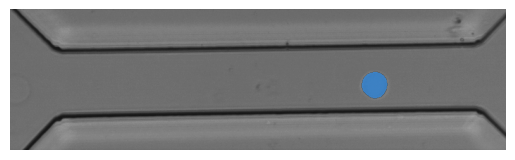

In [18]:
import matplotlib.pyplot as plt
import numpy as np 

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# Get the first image from training set
train_images = training_data["train"]["images"]
first_key = list(train_images.keys())[0]  # Get the first key (e.g., '86')
image = train_images[first_key]

# Get corresponding mask
train_masks = training_data["train"]["masks"]
mask = train_masks[first_key]

# Get the box prompt (same for all images)
box_prompt = training_data["train"]["box_prompt"]

# To visualize (using your existing plotting code)
fig, ax = plt.subplots()
ax.imshow(image)
show_mask(mask, ax)
ax.axis("off")

In [19]:
from transformers import SamProcessor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [20]:
class SAMDataset(Dataset):
    def __init__(self, data_dict, processor):
        self.images = data_dict['images']
        self.masks = data_dict['masks']
        self.box_prompt = data_dict['box_prompt']
        self.processor = processor
        self.keys = sorted(self.images.keys(), key=int)

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        image = self.images[key]
        ground_truth_mask = self.masks[key]

        # Store original image before processing
        original_image = image.copy()  # Make a copy to ensure it's not modified
        original_ground_truth_mask = ground_truth_mask.copy()

        # Process both image and mask together
        inputs = self.processor(
            images=image,
            segmentation_maps=ground_truth_mask,
            input_boxes=[[self.box_prompt.tolist()]],
            return_tensors="pt"
        )
        
        # Remove batch dimension
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        
        # The processed mask will be in inputs['labels']
        inputs["ground_truth_mask"] = inputs.pop('labels')
        
        # Add original image to inputs
        inputs["original_image"] = original_image

        inputs["original_ground_truth_mask"] = original_ground_truth_mask
        
        return inputs

train_dataset = SAMDataset(data_dict=training_data["train"], processor=processor)
val_dataset = SAMDataset(data_dict=training_data["val"], processor=processor)

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True)

# Test a single item
example = train_dataset[0]
print("Dataset item keys:", example.keys())
for k, v in example.items():
    print(f"{k}: {v.shape}")


Dataset item keys: dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'ground_truth_mask', 'original_image', 'original_ground_truth_mask'])
pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
ground_truth_mask: torch.Size([256, 256])
original_image: (200, 704, 3)
original_ground_truth_mask: (200, 704)


In [21]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])
original_image torch.Size([2, 200, 704, 3])
original_ground_truth_mask torch.Size([2, 200, 704])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7925336..0.8622224].


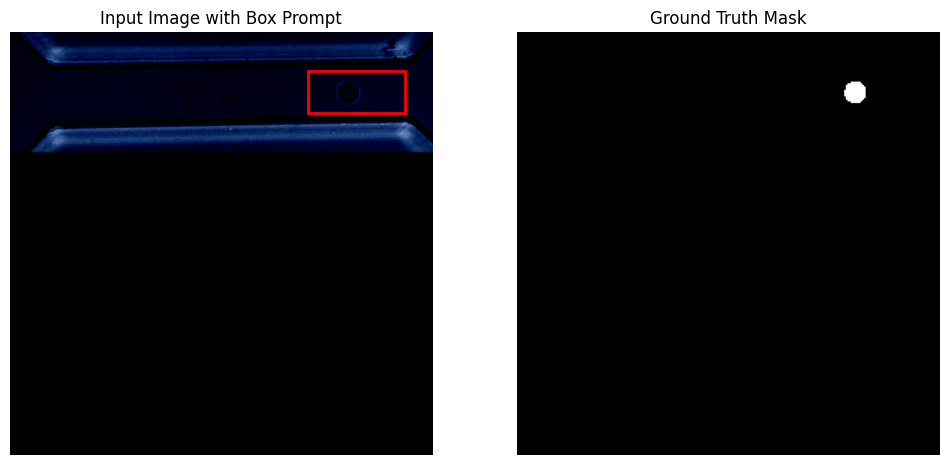

In [22]:
# # Visualise the input image and input ground truth to the model side by side
# # Extract the image and ground truth mask from the dataset
# example = train_dataset[0]
# image = example['pixel_values'].numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
# ground_truth_mask = example['ground_truth_mask'].numpy()
# box_prompt = example["box_prompts"]

# # Plot the image and ground truth mask side by side
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# axes[0].imshow(image)
# axes[0].set_title('Input Image')
# axes[0].axis('off')

# axes[1].imshow(ground_truth_mask, cmap='gray')
# axes[1].set_title('Ground Truth Mask')
# axes[1].axis('off')

# plt.show()

import matplotlib.patches as patches
# Visualise the input image and input ground truth to the model side by side
# Extract the image and ground truth mask from the dataset
example = train_dataset[0]
image = example['pixel_values'].numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
ground_truth_mask = example['ground_truth_mask'].numpy()
box_prompt = example["input_boxes"]

# Unpack the box coordinates
x0, y0, x1, y1 = box_prompt[0]

# Plot the image and ground truth mask side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot image with box prompt
axes[0].imshow(image)
axes[0].set_title('Input Image with Box Prompt')
axes[0].axis('off')

# Draw the box prompt on the image
rect = patches.Rectangle(
    (x0, y0), x1 - x0, y1 - y0,
    linewidth=2, edgecolor='r', facecolor='none'
)
axes[0].add_patch(rect)

# Plot ground truth mask
axes[1].imshow(ground_truth_mask, cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')


plt.show()

# Postprocessing Mask Result

Since SAM requires image transformation before inputting to the model therefore the input image, prompt and label also needs to be transformed with their library.

In [23]:
example = train_dataset[0]
# First reshape the tensor to have correct dimensions
ground_truth_mask = example['ground_truth_mask']  # Original tensor
original_sizes = example['original_sizes']
reshaped_input_sizes = example['reshaped_input_sizes']

# Ensure correct shape AND dtype for the tensor
if ground_truth_mask.dim() == 2:  # If it's just [H, W]
    mask_tensor = ground_truth_mask.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims -> [1, 1, H, W]
elif ground_truth_mask.dim() == 3:  # If it's [B, H, W] or [C, H, W]
    mask_tensor = ground_truth_mask.unsqueeze(1)  # Add missing dimension
elif ground_truth_mask.dim() == 4:  # If it's already [B, C, H, W]
    mask_tensor = ground_truth_mask
else:
    raise ValueError(f"Unexpected number of dimensions: {ground_truth_mask.dim()}")

# Convert to float tensor
mask_tensor = mask_tensor.float()

# Now create the lists for the post-processing function
masks_list = [mask_tensor]  # List containing the properly shaped tensor
original_sizes_list = [[original_sizes[0].item(), original_sizes[1].item()]]
reshaped_input_sizes_list = [[reshaped_input_sizes[0].item(), reshaped_input_sizes[1].item()]]

print("Debug info:")
print(f"Mask tensor shape: {mask_tensor.shape}")
print(f"Mask tensor dtype: {mask_tensor.dtype}")
print(f"Original sizes: {original_sizes_list}")
print(f"Reshaped input sizes: {reshaped_input_sizes_list}")

result = processor.image_processor.post_process_masks(
    masks=masks_list,
    original_sizes=original_sizes_list,
    reshaped_input_sizes=reshaped_input_sizes_list,
)


Debug info:
Mask tensor shape: torch.Size([1, 1, 256, 256])
Mask tensor dtype: torch.float32
Original sizes: [[200, 704]]
Reshaped input sizes: [[291, 1024]]


## Visualise postprocessing function result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7925336..0.8622224].


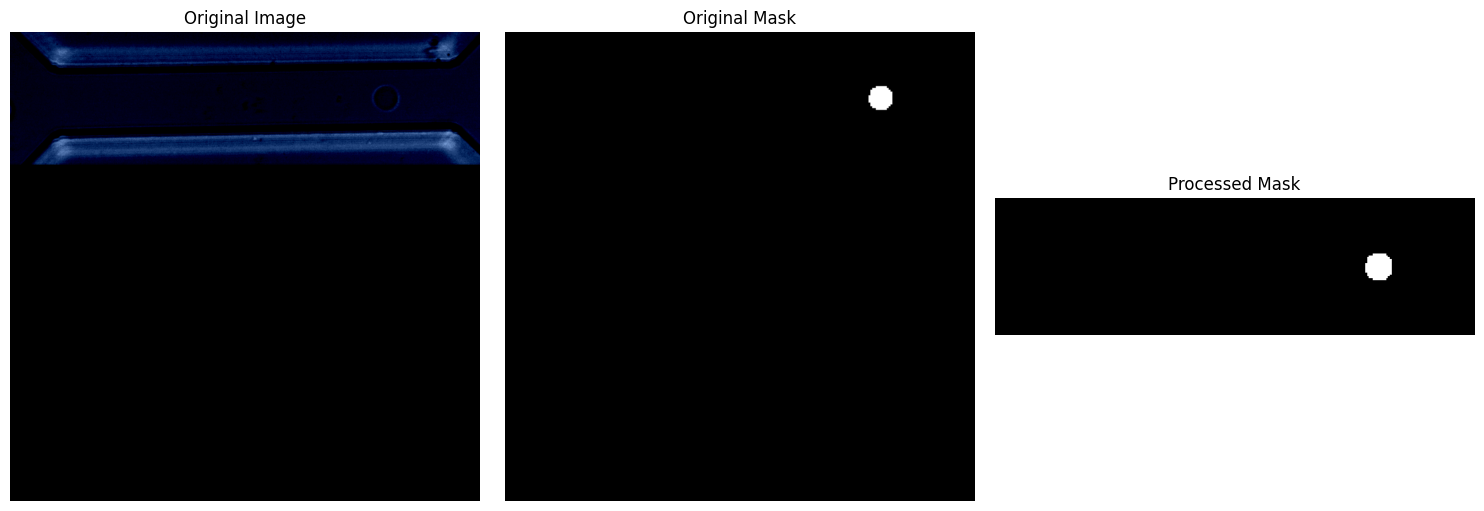

In [24]:
import matplotlib.pyplot as plt

def visualize_mask_result(image, original_mask, processed_mask):
    """
    Visualize original image, original mask, and processed mask side by side.
    
    Args:
        image: Original image tensor/array
        original_mask: Original mask before processing
        processed_mask: Processed mask from post_process_masks (list with one tensor)
    """
    # Convert processed mask from list to tensor
    processed_mask_tensor = processed_mask[0].squeeze()  # Remove batch and channel dimensions
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Plot original mask
    axes[1].imshow(original_mask, cmap='gray')
    axes[1].set_title('Original Mask')
    axes[1].axis('off')
    
    # Plot processed mask
    axes[2].imshow(processed_mask_tensor, cmap='gray')
    axes[2].set_title('Processed Mask')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Get original image and mask
original_image = example['pixel_values'].permute(1, 2, 0)  # Change from [C,H,W] to [H,W,C]
original_mask = example['ground_truth_mask']

# Visualize post processing
visualize_mask_result(original_image, original_mask, result)

# Training Loop

### Initialise model and loss

In [25]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [26]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

## Visualisaion of training images and predictions

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

# Create reporting directory if it doesn't exist
os.makedirs("reporting/sam_training", exist_ok=True)

def save_prediction_visualization(image, original_size, reshaped_input_size, pred_mask, gt_mask, batch_idx, epoch, processor):
    """Save visualization of prediction results
    image: original image without any transformations
    original_size: original size of the image
    pred_mask: predicted mask in 256*256 to be postprocessed by the processor in this function
    gt_mask: original ground truth mask
    """
    try:
        
        pred_mask_tensor = pred_mask.unsqueeze(1).float()  # Add missing dimension and to float

        # Move tensors to CPU
        pred_mask_tensor = pred_mask_tensor.cpu().detach()
        original_size = original_size.cpu().detach()
        reshaped_input_size = reshaped_input_size.cpu().detach()
        gt_mask = gt_mask.cpu().detach()
        image = image.cpu().detach()
        
        # Now create the lists for the post-processing function        
        pred_masks_list = [pred_mask_tensor]  # List containing the properly shaped tensor
        original_sizes_list = [[original_size[0].item(), original_size[1].item()]]
        reshaped_input_sizes_list = [[reshaped_input_size[0].item(), reshaped_input_size[1].item()]]
        
        # print("Debug info:")
        # print(f"Pred Mask shape: {pred_mask.shape}")
        # print(f"Mask tensor shape: {mask_tensor.shape}")
        # print(f"Mask tensor dtype: {mask_tensor.dtype}")
        # print(f"Original sizes: {original_sizes_list}")
        # print(f"Reshaped input sizes: {reshaped_input_sizes_list}")

        # Post process the predicted mask
        result = processor.image_processor.post_process_masks(
            masks=pred_masks_list,
            original_sizes=original_sizes_list,
            reshaped_input_sizes=reshaped_input_sizes_list
        )

         # Remove batch and channel dimensions
        image_np = image.squeeze().numpy()           # Shape: (200, 704)
        
        gt_mask_np = gt_mask.squeeze().numpy()       # Shape: (200, 704)
        
        result_np = result[0].squeeze()              # Ensure result is 2D
        
        # print(f"Image_np shape: {image_np.shape}")
        # print(f"Ground truth mask shape: {gt_mask_np.shape}")
        # print(f"Postprocessed Predicted Mask: {result_np.shape}")
        

        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Overlay predicted mask
        axes[0].imshow(image_np)
        axes[0].imshow(result_np, cmap='jet', alpha=0.5)
        axes[0].set_title('Predicted Mask Overlay')
        axes[0].axis('off')

        # Overlay ground truth mask
        axes[1].imshow(image_np)
        axes[1].imshow(gt_mask_np, cmap='jet', alpha=0.5)
        axes[1].set_title('Ground Truth Mask Overlay')
        axes[1].axis('off')

        # Overlay both masks
        axes[2].imshow(image_np)
        axes[2].imshow(result_np, cmap='jet', alpha=0.5)
        axes[2].imshow(gt_mask_np, cmap='gray', alpha=0.3)
        axes[2].set_title('Predicted and Ground Truth Overlay')
        axes[2].axis('off')

        # Save with error handling
        save_path = f'reporting/sam_training/epoch_{epoch}_batch_{batch_idx}.png'
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()
        
    except Exception as e:
        logger.error(f"Error saving visualization: {str(e)}")
        plt.close()  # Ensure figure is closed even if save fails

### Training and validation loop

In [28]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    epoch_losses = []
    for batch_idx, batch in tqdm(enumerate(train_dataloader), desc=f"Training epoch {epoch}"):
        # forward pass
        outputs = model(
            pixel_values=batch["pixel_values"].to(device),
            input_boxes=batch["input_boxes"].to(device),
            multimask_output=False
        )
        
        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        
        # Visualize training predictions
        
        save_prediction_visualization(
                image=batch["original_image"][0],
                original_size=batch["original_sizes"][0],
                reshaped_input_size=batch["reshaped_input_sizes"][0],
                pred_mask=predicted_masks[0],
                gt_mask=batch["original_ground_truth_mask"][0],
                batch_idx=batch_idx,
                epoch=epoch,
                processor=processor
            )
        # Visualize training predictions
        # if batch_idx % 10 == 0:
        #     save_prediction_visualization(
        #         image=batch["original_image"][0],
        #         original_size=batch["original_sizes"][0],
        #         reshaped_input_size=batch["reshaped_input_sizes"][0],
        #         pred_mask=predicted_masks[0],
        #         gt_mask=batch["original_ground_truth_mask"][0],
        #         batch_idx=batch_idx,
        #         epoch=epoch,
        #         processor=processor
        #     )

    train_loss = mean(epoch_losses)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_epoch_losses = []
    
    with torch.no_grad():  # Disable gradient computation
        for batch_idx, batch in tqdm(enumerate(val_dataloader), desc=f"Validation epoch {epoch}"):
            # forward pass
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                input_boxes=batch["input_boxes"].to(device),
                multimask_output=False
            )
            
            # compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            val_loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
            val_epoch_losses.append(val_loss.item())

            # # Visualize validation predictions
            # if batch_idx % 10 == 0:
            #     save_prediction_visualization(
            #         image=batch["original_image"][0],
            #         original_size=batch["original_sizes"][0],
            #         reshaped_input_size=batch["reshaped_input_sizes"][0],
            #         pred_mask=predicted_masks[0],
            #         gt_mask=batch["original_ground_truth_mask"][0],
            #         batch_idx=batch_idx,
            #         epoch=epoch,
            #         processor=processor
            #     )

    val_loss = mean(val_epoch_losses)
    val_losses.append(val_loss)

    # Save best model
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     torch.save(model.state_dict(), 'best_model.pth')

    print(f'EPOCH: {epoch}')
    print(f'Training loss: {train_loss:.4f}')
    print(f'Validation loss: {val_loss:.4f}')

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.savefig('loss_plot.png')
plt.close()



Training epoch 0: 77it [00:47,  1.64it/s]
Validation epoch 0: 20it [00:05,  3.68it/s]


EPOCH: 0
Training loss: 0.1145
Validation loss: 0.0360


Training epoch 1: 77it [00:44,  1.72it/s]
Validation epoch 1: 20it [00:05,  3.72it/s]


EPOCH: 1
Training loss: 0.0261
Validation loss: 0.0239


Training epoch 2: 77it [00:45,  1.70it/s]
Validation epoch 2: 20it [00:05,  3.80it/s]


EPOCH: 2
Training loss: 0.0193
Validation loss: 0.0190


Training epoch 3: 77it [00:45,  1.70it/s]
Validation epoch 3: 20it [00:05,  3.80it/s]


EPOCH: 3
Training loss: 0.0163
Validation loss: 0.0180


Training epoch 4: 77it [00:48,  1.58it/s]
Validation epoch 4: 20it [00:05,  3.59it/s]


EPOCH: 4
Training loss: 0.0150
Validation loss: 0.0152


Training epoch 5: 77it [00:50,  1.52it/s]
Validation epoch 5: 20it [00:05,  3.61it/s]


EPOCH: 5
Training loss: 0.0131
Validation loss: 0.0152


Training epoch 6: 77it [00:52,  1.47it/s]
Validation epoch 6: 20it [00:05,  3.56it/s]


EPOCH: 6
Training loss: 0.0129
Validation loss: 0.0146


Training epoch 7: 77it [00:49,  1.55it/s]
Validation epoch 7: 20it [00:05,  3.60it/s]


EPOCH: 7
Training loss: 0.0115
Validation loss: 0.0124


Training epoch 8: 77it [00:50,  1.51it/s]
Validation epoch 8: 20it [00:05,  3.62it/s]


EPOCH: 8
Training loss: 0.0106
Validation loss: 0.0128


Training epoch 9: 77it [00:49,  1.56it/s]
Validation epoch 9: 20it [00:05,  3.75it/s]


EPOCH: 9
Training loss: 0.0105
Validation loss: 0.0132


Training epoch 10: 77it [00:49,  1.56it/s]
Validation epoch 10: 20it [00:05,  3.58it/s]


EPOCH: 10
Training loss: 0.0099
Validation loss: 0.0132


Training epoch 11: 77it [00:53,  1.45it/s]
Validation epoch 11: 20it [00:05,  3.58it/s]


EPOCH: 11
Training loss: 0.0094
Validation loss: 0.0137


Training epoch 12: 77it [00:50,  1.54it/s]
Validation epoch 12: 20it [00:05,  3.57it/s]


EPOCH: 12
Training loss: 0.0099
Validation loss: 0.0141


Training epoch 13: 77it [00:50,  1.53it/s]
Validation epoch 13: 20it [00:05,  3.65it/s]


EPOCH: 13
Training loss: 0.0090
Validation loss: 0.0126


Training epoch 14: 77it [00:54,  1.42it/s]
Validation epoch 14: 20it [00:05,  3.57it/s]


EPOCH: 14
Training loss: 0.0085
Validation loss: 0.0144


Training epoch 15: 77it [00:50,  1.53it/s]
Validation epoch 15: 20it [00:05,  3.58it/s]


EPOCH: 15
Training loss: 0.0079
Validation loss: 0.0137


Training epoch 16: 77it [00:50,  1.53it/s]
Validation epoch 16: 20it [00:05,  3.54it/s]


EPOCH: 16
Training loss: 0.0075
Validation loss: 0.0126


Training epoch 17: 77it [00:53,  1.43it/s]
Validation epoch 17: 20it [00:05,  3.45it/s]


EPOCH: 17
Training loss: 0.0070
Validation loss: 0.0135


Training epoch 18: 77it [00:51,  1.50it/s]
Validation epoch 18: 20it [00:05,  3.54it/s]


EPOCH: 18
Training loss: 0.0070
Validation loss: 0.0147


Training epoch 19: 77it [00:49,  1.55it/s]
Validation epoch 19: 20it [00:05,  3.52it/s]


EPOCH: 19
Training loss: 0.0068
Validation loss: 0.0141


In [33]:
# torch.save(model.state_dict(), 'sam_bead.pth')
# Save the fine-tuned model and processor
model.save_pretrained('sam_bead')
processor.save_pretrained('sam_bead_processor')

[]

# Inference

In [34]:
# prepare the model for inference mode
from transformers import SamProcessor, SamModel
processor = SamProcessor.from_pretrained('sam_bead_processor')
model = SamModel.from_pretrained('sam_bead')
model.eval()

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [127]:

class PrepareSAMDataset(Dataset):
    def __init__(self, images_dict, roi, processor):
        self.images = images_dict
        self.roi = roi.iloc[0].values.astype(float)
        self.processor = processor
        self.keys = sorted(self.images.keys(), key=lambda x: int(x.split('_')[-1]) if x.split('_')[-1].isdigit() else float('inf'))


    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        image = self.images[key]()
        # Store original image before processing
        image = np.array(image)
        image = np.stack([image] * 3, axis=-1) if image.ndim == 2 else image
        original_image = image.copy()
        # Convert ROI from x, y, width, height to x_min, y_min, x_max, y_max
        x, y, width, height = self.roi
        box_prompt = [x, y, x + width, y + height]

        # Process the image
        inputs = self.processor(
            images=image,
            input_boxes=[[box_prompt]],
            return_tensors="pt"
        )
        
        # Remove batch dimension
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        
        # Add original image to inputs
        inputs["original_image"] = original_image

        return inputs

class SamInference:
    def __init__(self, model_path, processor_path):
        # Load the processor and model
        self.processor = SamProcessor.from_pretrained(processor_path)
        self.model = SamModel.from_pretrained(model_path)
        self.model.eval()  # Set the model to evaluation mode
        # Set model to device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)
        print("Device: ", next(self.model.parameters()).device)

    def perform_inference(self, dataloader):
        results = []
        for batch in dataloader:
            pixel_values = batch['pixel_values'].to(self.device)
            input_boxes = batch['input_boxes'].to(self.device)
            original_image = batch['original_image']

            # Perform inference
            with torch.no_grad():
                outputs = self.model(
                    pixel_values=pixel_values,
                    input_boxes=input_boxes,
                    multimask_output=False
                )
                predicted_masks = outputs.pred_masks

            # Post-process the predicted masks
            masks = self.processor.image_processor.post_process_masks(
                predicted_masks,
                batch["original_sizes"],
                batch["reshaped_input_sizes"]
            )

            # Store the original image and mask
            results.append({
                'original_image': original_image,
                'masks': masks
            })



            # # Remove batch dimension from original_image
            # original_image = original_image.squeeze(0)
            # masks = masks[0].squeeze(0)


            # print(f"Original image shape: {original_image.shape}")
            # print(f"Mask shape: {masks[0].shape}")
            # # Visualize or utilize the masks
            # plt.imshow(original_image)
            # plt.imshow(masks[0], alpha=0.5, cmap='jet')  # Adjust indexing as needed
            # plt.axis('off')
            # plt.show()
        return results
# Example usage
data_dict = {
    'images': batch_image,  # Your batch_image dictionary
    'box_prompt': batch_roi  # Example ROI in x, y, width, height format
}

In [128]:
# Create dataset and dataloader
processor = SamProcessor.from_pretrained('sam_bead_processor')
dataset = PrepareSAMDataset(data_dict['images'], data_dict['box_prompt'], processor)
dataloader = DataLoader(dataset, batch_size=1)

# Perform inference
inference = SamInference('sam_bead', 'sam_bead_processor')
pred_pair = inference.perform_inference(dataloader)

Device:  cuda:0


## Visualise Inference Results

Mask shape: torch.Size([200, 704])
Image shape: torch.Size([200, 704, 3])


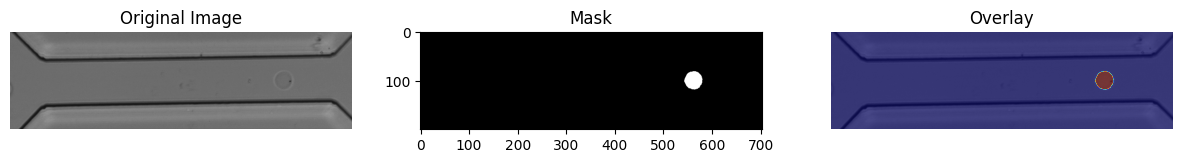

In [150]:
import matplotlib.pyplot as plt

# Assuming pred_pair is the result from perform_inference
mask_example = pred_pair[0]['masks'][0].cpu()  # Get the first mask from the first result
image_example = pred_pair[0]['original_image'].cpu()  # Get the corresponding original image

# If the mask has an extra dimension, squeeze it
if mask_example.ndim == 4:
    mask_example = mask_example.squeeze(0).squeeze(0)

if image_example.ndim == 4:
    image_example = image_example.squeeze(0)

print(f"Mask shape: {mask_example.shape}")
print(f"Image shape: {image_example.shape}")

plt.figure(figsize=(15,5))
# plt original image
plt.subplot(1,3,1)
plt.imshow(image_example)
plt.title('Original Image')
plt.axis('off')
# plt the mask
plt.subplot(1,3,2)
plt.imshow(mask_example, cmap='gray')
plt.title('Mask')

plt.subplot(1,3,3)
plt.imshow(image_example)
plt.imshow(mask_example, alpha=0.5, cmap='jet')
plt.title('Overlay')
plt.axis('off')

plt.show()

# Get DI and Area from results

In [162]:
import cv2

def process_masks(pred_pair):
    for result in pred_pair:
        contours_info = []
        for mask in result['masks']:
            # Convert mask to numpy array if it's not already
            mask = mask.cpu().numpy()
            
            if mask.ndim == 4:
                mask = mask.squeeze(0).squeeze(0)
            
            mask = mask.astype(np.uint8)
            # Find contours
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            # Check if there is more than one contour
            if len(contours) > 1:
                result['DI'] = None
                break

            for contour in contours:
                # Calculate area
                area = cv2.contourArea(contour)
                
                # Calculate perimeter
                perimeter = cv2.arcLength(contour, True)
                
                # Calculate deformability (perimeter to area ratio)
                deformability = perimeter / area if area != 0 else 0
                
                convex_hull = cv2.convexHull(contour)

                # Calculate convex hull area
                convex_hull_area = cv2.contourArea(convex_hull)
                
                # Calculate area ratio between convex hull and contour
                area_ratio = convex_hull_area / area if area != 0 else 0

                contours_info.append({
                    'contour': contour,
                    'area': area,
                    'deformability': deformability,
                    'area_ratio': area_ratio
                })
        
        result['DI'] = contours_info

    return pred_pair

pred_pair = process_masks(pred_pair)

### Examine DI content

In [163]:
if pred_pair[0]['DI'] is not None:
    for idx, info in enumerate(pred_pair[0]['DI']):
        print(f"Contour {idx + 1}:")
        print(f"  Area: {info['area']}")
        print(f"  Deformability: {info['deformability']}")
        print(f"  Area Ratio: {info['area_ratio']}")
else:
    print("More than one contour found, contours_info is None.")

Contour 1:
  Area: 1020.5
  Deformability: 0.11919608903480242
  Area Ratio: 1.0269475747182752


# Plot scatter plot